In [1]:
# import basic packages for managing dataframe
import pandas as pd
import numpy as np
from datetime import datetime

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# regardless warnings
import warnings 
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# import model package 
# regression and classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

#clustering
from sklearn.cluster import KMeans

# import measurement package
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn import metrics


# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df_train_1 = pd.read_csv('train_tfidf_by_article.csv',engine='python')
df_test_1 = pd.read_csv('test_tfidf_by_article.csv',engine='python')

In [3]:
len(df_train_1)

14367

In [4]:
len(df_test_1)

3592

# 1. Check train and test dataset

In [5]:
def train_test_check(df_train, df_test):

    sum_train=[]
    sum_test=[]

    for num_models in range(0,200): 
        # create y_train and y_test
        y_train = []
        y_test = []
        for i  in range(len(df_train)):
            y_train.append(int(df_train['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
        for j  in range(len(df_test)):
            y_test.append(int(df_test['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))

        sum_train.append(sum(y_train))
        sum_test.append(sum(y_test))

    # save result in train_test dataframe
    data_tuples = list(zip(sum_train,sum_test))
    train_test = pd.DataFrame(data_tuples,columns=['sum_train','sum_test'])
    print('There are ',len(train_test[train_test['sum_test']==0]), 'tags that never occur in test dataset')

    return train_test

In [6]:
train_test = train_test_check(df_train_1,df_test_1)

There are  23 tags that never occur in test dataset


# 2. Get new tag index list
(remove those tags that never occur in test dataset in both train and test)

Since there are 200 tags in orginal train and test dataset, but there are some tags never occurring in test dataset. So, I removed those tag and get the new tag index list in order to use it in the model part. 

In [7]:
def tag_new(df):
    tag_index_original = list(range(0, 200))
    tag_index_new=[]
    for i in tag_index_original:
        if i in df[df['sum_test']==0].index:
            pass
        else:
            tag_index_new.append(i)
    return tag_index_new

In [8]:
tag_index_new = tag_new(train_test)

# 3. Shape Y and X

In [9]:
columns_not_include = ['RECORDID','Tags','Tag_Count' 'Vec_Tags', 'Body', 'Body_Lemm',
       'Body_Lemm_lower', 'Body_Token','Body_Length','Title', 'Title_Lemm',
       'Title_Lemm_lower', 'Title_Token']

# split train and test
X_train = df_train_1.loc[:, ~df_train_1.columns.isin(columns_not_include)]

X_test = df_test_1.loc[:, ~df_test_1.columns.isin(columns_not_include)]


X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]


In [10]:
# Run PCA for the total dataset(Train+Test)

#X_total = pd.concat([X_train, X_test])
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.9)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))



In [11]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,523,524,525,526,527,528,529,530,531,532
0,-1.920360,-2.025307,-0.488035,-3.734308,2.298330,9.016640,-4.803307,-5.506217,-0.715598,2.214637,...,1.241815,-0.107761,-0.058666,0.121002,-1.596618,-0.466684,-1.090763,0.074548,0.530112,1.700956
1,-1.025135,-2.088423,-0.303601,-0.490502,-0.830195,-2.260281,-2.661216,0.527168,1.202328,-2.988569,...,0.233506,-0.282613,-0.809022,0.188899,0.610206,-0.437351,-1.148587,-0.176996,-0.206910,-0.228192
2,-0.633747,-1.865797,11.810453,-9.687797,-1.314967,22.681561,-2.102608,-13.534158,-1.359852,3.228489,...,-1.021376,1.298406,-0.802384,0.578871,0.764142,-1.581936,-1.555181,1.637535,-1.389879,1.906686
3,-0.802478,-1.927446,-1.877104,1.001584,1.248444,-1.363873,-1.854483,0.724771,0.841190,-1.684479,...,-0.735470,0.305045,-0.406287,-0.205839,0.064388,-1.999274,-0.085321,-1.028099,0.245345,-1.180944
4,-0.771136,-2.300049,-2.190940,1.785200,-0.394352,-1.249311,-2.195010,0.573357,0.215922,0.390370,...,1.467404,-1.224910,-0.217043,-0.035445,-1.390102,0.399769,0.256487,0.779975,0.101936,0.431399


In [12]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,523,524,525,526,527,528,529,530,531,532
0,-0.621252,-2.386410,-0.973592,5.029580,0.813045,-1.110251,-2.916245,0.734961,-1.450492,-1.957928,...,0.936226,-0.651705,-0.927697,-0.018274,0.021003,0.419202,-0.101816,-0.494140,0.051704,0.330897
1,-1.266339,-2.257428,-4.019359,-1.681501,4.389693,-2.911988,1.278999,1.832752,-0.513387,-0.622428,...,1.225843,0.520471,0.024277,0.424129,0.329023,-1.026057,-1.036683,-0.612735,0.591435,-0.717920
2,-1.480727,-3.030803,7.061632,6.327930,-11.847097,4.675818,12.761250,-1.275543,-1.458532,0.459931,...,-0.054193,0.943915,-0.549627,-0.502465,1.709382,0.238153,0.717796,-1.488422,-0.522473,-0.435056
3,-0.924857,-2.613334,-3.459448,0.316734,-0.726264,-0.311774,-1.430269,0.187544,-0.266061,-2.813617,...,-0.333675,-0.284693,-1.377223,0.094167,-1.039133,0.127921,0.393092,0.137543,0.246720,1.263986
4,-1.378592,-3.083908,-1.267404,10.522808,-10.205247,3.220854,12.659246,-0.219020,1.427060,-1.358369,...,-0.054182,-0.015319,-0.000714,-0.060848,-0.198140,-0.243166,-0.330198,0.072019,0.605127,0.554965


# 4. Models

# 4.1 Logistic regression

In [13]:
accuracy = []
f1_score=[]
roc = []
# compute how many 1 in each model
sum_train=[]
sum_test=[]

X_train_lg = X_train.copy()
X_test_lg = X_test.copy()
for num_models in tag_index_new: 
    # create y_train and y_test
    y_train = []
    y_test = []
    for i  in range(len(df_train_1)):
        y_train.append(int(df_train_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_1)):
        y_test.append(int(df_test_1['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    # logistic regression
    lg = LogisticRegression().fit(X_train_lg, y_train)
    y_pred_lg_test = lg.predict(X_test_lg)
    y_pred_lg_train = lg.predict(X_train_lg)
    y_score_lg_test = lg.predict_proba(X_test_lg)[:,1]
    y_score_lg_train = lg.predict_proba(X_train_lg)[:,1]
    acc_lg = accuracy_score(y_test, y_pred_lg_test)
    f1_score_lg = metrics.f1_score(y_test, y_pred_lg_test)
    roc_lg = metrics.roc_auc_score(y_test, y_pred_lg_test)
    accuracy.append(acc_lg)
    f1_score.append(f1_score_lg)
    roc.append(roc_lg)
    
    # create new column: the predict result for the next model
    X_train_lg['predict_'+str(num_models)] = y_pred_lg_train
    X_test_lg['predict_'+str(num_models)] = y_pred_lg_test

In [14]:
data_tuples = list(zip(accuracy,f1_score,roc,sum_train,sum_test))
result_lg = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result_lg['sum_train'] = result_lg['sum_train']/len(y_train)
result_lg['sum_test'] = result_lg['sum_test']/len(y_test)

In [15]:
# Here is the result for 177 models(since 177 tags)
result_lg

,accuracy,f1_score,roc,sum_train,sum_test
0,0.996102,0.766667,0.958318,0.009814,0.006960
1,0.997494,0.769231,0.825947,0.007030,0.006403
2,0.997216,0.736842,0.817902,0.006960,0.006125
3,0.990813,0.507463,0.740749,0.006821,0.009744
4,0.990813,0.507463,0.740749,0.006821,0.009744
...,...,...,...,...,...
172,0.999722,0.000000,0.500000,0.000418,0.000278
173,0.999443,0.500000,0.666667,0.000418,0.000835
174,1.000000,1.000000,1.000000,0.000418,0.000835
175,0.999722,0.666667,0.750000,0.000418,0.000557


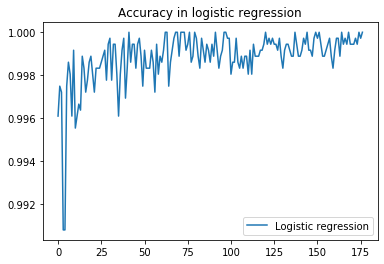

In [16]:
plt.plot(result_lg.accuracy,label='Logistic regression')
plt.title('Accuracy in logistic regression')
#plt.xlim(0,9)
plt.legend()
plt.show()

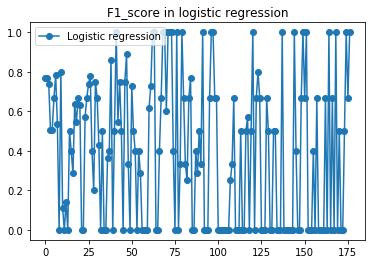

In [17]:
plt.plot(result_lg.f1_score,label='Logistic regression',marker='o')
plt.title('F1_score in logistic regression')
#plt.xlim(0,9)
plt.legend()
plt.show()

# 4.2 Random Forest

In [91]:
accuracy_rf = []
f1_score_rf = []
roc_rf = []

# compute how many 1 in each model
sum_train=[]
sum_test=[]

X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

for num_models in tag_index_new: 
    # create train and test
    y_train = []
    y_test = []
    for i  in range(len(df_train_1)):
        y_train.append(int(df_train_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_1)):
        y_test.append(int(df_test_1['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    
    # Random Forest
    rf = RandomForestClassifier(max_depth=5,class_weight='balanced').fit(X_train_rf, y_train)
    y_pred_rf_test = rf.predict(X_test_rf)
    y_pred_rf_train = rf.predict(X_train_rf)
    y_score_rf = rf.predict_proba(X_test_rf)[:,1]
    acc_rf = accuracy_score(y_test, y_pred_rf_test)
    f1_score_rf_result = metrics.f1_score(y_test, y_pred_rf_test)
    roc_rf_result = metrics.roc_auc_score(y_test, y_score_rf)
    accuracy_rf.append(acc_rf)
    f1_score_rf.append(f1_score_rf_result)
    roc_rf.append(roc_rf_result)
    
    # create new column: the predict result for the next model
    X_train_rf['predict_'+str(num_models)] = y_pred_rf_train
    X_test_rf['predict_'+str(num_models)] = y_pred_rf_test

KeyboardInterrupt: 

In [ ]:
data_tuples = list(zip(accuracy_rf,f1_score_rf,roc_rf,sum_train,sum_test))
result_rf = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result_rf['sum_train'] = result_rf['sum_train']/len(y_train)
result_rf['sum_test'] = result_rf['sum_test']/len(y_test)
result_rf

In [ ]:
result_rf.f1_score.mean()

# Calculate accuracy score for each article

In [18]:
# Calculate accuracy score for each article
def accuracy_by_article(df):
    result_predict = df.iloc[:,-177:]
    wrong_result_predict=[]
    for i in range(len(result_predict)):
        difference_article=[]
        for index,element in enumerate(tag_index_new):
            # check whether predicted value is equal to the true value
            difference_article.append(abs(result_predict.iloc[i][index] - int(df_test_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[element].rstrip(' ').lstrip(' '))))
        wrong_result_predict.append(sum(difference_article))   
    
    # Create the dataframe of number of tags that are predicted wrongly and the tag_count for each article
    data_tuples = list(zip(wrong_result_predict,df_test_1['Tag_Count']))
    accuracy_article= pd.DataFrame(data_tuples,columns=['Num_tag_predict_wrong','Tag_Count'])
    
    # Add the accuracy column to calculate the accuracy score for each article
    accuracy_article['accuracy_article'] = ''
    for i in range(len(accuracy_article)):
        if accuracy_article['Num_tag_predict_wrong'].iloc[i]==0:
            accuracy_article['accuracy_article'].iloc[i]=1
        else:
            accuracy_article['accuracy_article'].iloc[i] = 1.0-(accuracy_article['Num_tag_predict_wrong'].iloc[i]/len(tag_index_new))

    return accuracy_article

In [19]:
a=accuracy_by_article(X_test_lg)

In [112]:
a.to_csv('Article accuracy_lg.csv')

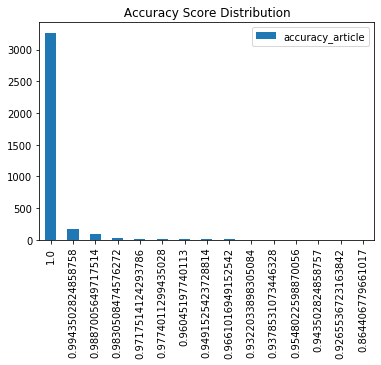

In [26]:
a.accuracy_article.value_counts().plot(kind='bar')
plt.title(' Accuracy Score Distribution ')
#plt.xlim(0,9)
#plt.legend()
plt.show()